In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoImageProcessor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import PPO

import torch.nn as nn
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
from torch.utils.data import DataLoader

from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.config import DEVICE
from uav_active_sensing.plots import visualize_tensor

2025-02-25 14:35:56.865 | INFO     | uav_active_sensing.config:<module>:14 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
2025-02-25 14:35:56.866 | INFO     | uav_active_sensing.config:<module>:49 - Using device: cpu


In [3]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)  # TODO: Download this in advance
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=4, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")  # TODO: Download this in advance
reward_function = RewardFunction(mae_model)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization

env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].


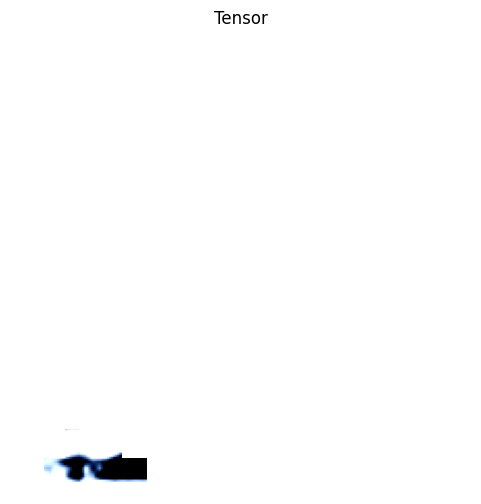

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0434113].


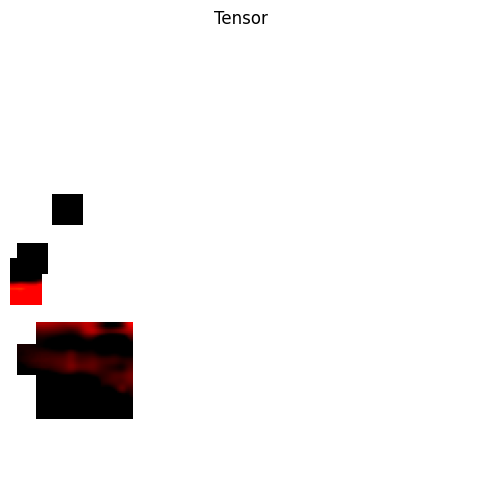

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1165345..2.4196956].


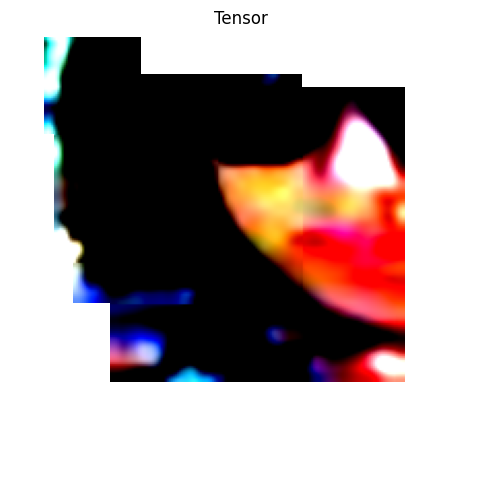

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.821075..2.64].


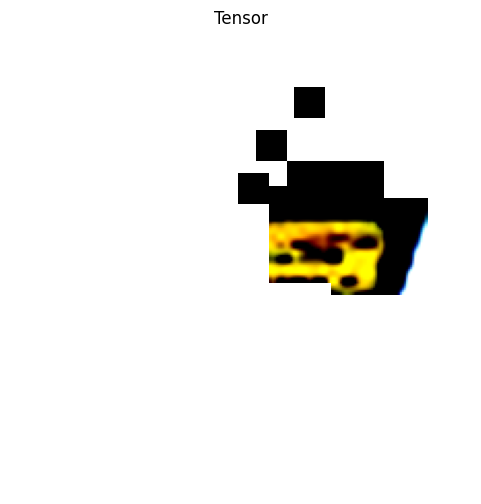

In [4]:
env.reset()
for j in range(5):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)

for k in range(env.batch_size):
    visualize_tensor(env.sampled_img[k])



In [5]:
obs= env._get_obs()

In [6]:
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
class CustomResNetFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        super(CustomResNetFeatureExtractor, self).__init__(observation_space, features_dim)
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        for param in resnet.parameters():
            param.requires_grad = False  # Freeze the weights
        
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        # self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self._features_dim = features_dim

    def forward(self, observations):
        """
        observations: expect a tensor of shape (batch_size, num_images, channels, height, width)
        """
        batch_size, num_images, C, H, W = observations.shape
        print(f"batch_size: {batch_size}")
        print(f"num_images: {num_images}")
        print(f"C: {C}")
        print(f"H: {H}")
        print(f"W: {W}")
        
        observations = observations.view(-1, C, H, W)
        print(observations.shape)
        features = self.resnet(observations)
        # print(features.shape)
        # features = self.global_avg_pool(features)
        print(features.shape)
        # features = features.view(features.size(0), -1)
        # print(features.shape)
        features = features.view(batch_size, num_images, -1)
        print(features.shape)
        aggregated_features = features.mean(dim=1)
        print(aggregated_features.shape)


        return aggregated_features

feature_extractor = CustomResNetFeatureExtractor(observation_space=None).to(DEVICE)


In [8]:
rl_num_envs = 1
rl_batch_size = 4
rl_num_steps = rl_batch_size * rl_num_envs * 4

policy_kwargs = dict(
    features_extractor_class=CustomResNetFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=512), # 4 is img batch size
)

env.reset()
resnet_rl_model = PPO(
    "CnnPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_steps=rl_num_steps,
    batch_size=rl_batch_size,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
resnet_rl_model.predict(env._get_obs())

batch_size: 1
num_images: 4
C: 3
H: 224
W: 224
torch.Size([4, 3, 224, 224])
torch.Size([4, 512, 1, 1])
torch.Size([1, 4, 512])
torch.Size([1, 512])


(array([[-1.        , -1.        , -0.24549578],
        [ 0.47271565, -0.6082851 ,  1.        ],
        [ 0.6295405 , -1.        , -0.17514281],
        [ 1.        ,  0.8974461 , -0.07903823]], dtype=float32),
 None)

In [10]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)  # TODO: Download this in advance
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")  # TODO: Download this in advance
reward_function = RewardFunction(mae_model)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization

env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
new_env = ImageExplorationEnv(env_config)

In [14]:
resnet_rl_model.action_space

Box(-1.0, 1.0, (4, 3), float32)

In [12]:
resnet_rl_model.predict(new_env._get_obs())

ValueError: Error: Unexpected observation shape (1, 3, 224, 224) for Box environment, please use (4, 3, 224, 224) or (n_env, 4, 3, 224, 224) for the observation shape.